# Spark LLM Assistant

## Initialization

In [1]:
from langchain.chat_models import ChatOpenAI
from spark_llm import SparkLLMAssistant

llm = ChatOpenAI(model_name='gpt-4') # using gpt-4 can achieve better results
assistant=SparkLLMAssistant(llm=llm, verbose=True)
assistant.activate() # active partial functions for Spark DataFrame

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/20 14:43:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Example 1: Auto sales by brand in US 2022

In [2]:
# Search and ingest web content into a DataFrame
auto_df = assistant.create_df("2022 USA national auto sales by brand")
auto_df.show()

Parsing URL: https://www.carpro.com/blog/full-year-2022-national-auto-sales-by-brand

SQL query for the ingestion:
 CREATE OR REPLACE TEMP VIEW auto_sales_2022 AS SELECT * FROM VALUES
('Toyota', 1849751, -9),
('Ford', 1767439, -2),
('Chevrolet', 1502389, 6),
('Honda', 881201, -33),
('Hyundai', 724265, -2),
('Kia', 693549, -1),
('Jeep', 684612, -12),
('Nissan', 682731, -25),
('Subaru', 556581, -5),
('Ram Trucks', 545194, -16),
('GMC', 517649, 7),
('Mercedes-Benz', 350949, 7),
('BMW', 332388, -1),
('Volkswagen', 301069, -20),
('Mazda', 294908, -11),
('Lexus', 258704, -15),
('Dodge', 190793, -12),
('Audi', 186875, -5),
('Cadillac', 134726, 14),
('Chrysler', 112713, -2),
('Buick', 103519, -42),
('Acura', 102306, -35),
('Volvo', 102038, -16),
('Mitsubishi', 102037, -16),
('Lincoln', 83486, -4),
('Porsche', 70065, 0),
('Genesis', 56410, 14),
('INFINITI', 46619, -20),
('MINI', 29504, -1),
('Alfa Romeo', 12845, -30),
('Maserati', 6413, -10),
('Bentley', 3975, 0),
('Lamborghini', 3134, 3),
('Fi

You can use the `plotly` library to visualize the result of the `df` DataFrame. Here's a sample code block that demonstrates how to create a bar chart using this library:

```python
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# Convert the Spark DataFrame to a Pandas DataFrame
pdf = df.toPandas()

# Initialize notebook mode for plotly
init_notebook_mode(connected=True)

# Create a bar chart with plotly
trace = go.Bar(
    x=pdf['brand'],
    y=pdf['us_sales'],
    text=pdf['sales_change_percentage'],
    textposition='auto',
    marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(color='rgba(50, 171, 96, 1.0)', width=1)
    ),
    opacity=0.8
)

data = [trace]

layout = go.Layout(
    title='US Auto Sales Data in 2022',
    xaxis=dict(title='Brand'),
    yaxis=dict(title='US Sales'),
)

fig = go.Figure(data=data, layout=layout)

# Show the plot directly in the notebook
iplot(fig)
```

This code block:
1. Converts the PySpark D

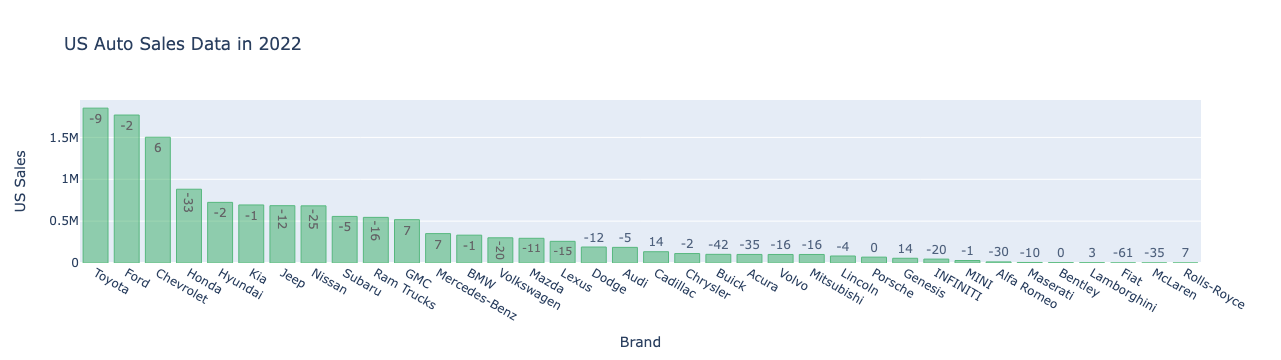

In [3]:
auto_df.llm.plot()

In [4]:
# Apply transforms to a Dataframe
auto_top_growth_df=auto_df.llm.transform("top brand with the highest growth")
auto_top_growth_df.show()

SQL query for the transform:
SELECT brand, sales_change_percentage
FROM temp_view_for_transform
ORDER BY sales_change_percentage DESC
LIMIT 1
+--------+-----------------------+
|   brand|sales_change_percentage|
+--------+-----------------------+
|Cadillac|                     14|
+--------+-----------------------+



In [5]:
# Explain what a DataFrame is retrieving.
auto_top_growth_df.llm.explain()

'In summary, this dataframe is retrieving the brand with the highest sales change percentage from the `temp_view_for_transform` view, which contains data on brand, US sales, and sales change percentage.'

In [6]:
auto_top_growth_df.llm.verify("expect sales change percentage to be between -100 to 100")

Generated code:
def valid_sales_change_percentage(df) -> bool:
    # Check if the sales_change_percentage column exists in the DataFrame
    if "sales_change_percentage" not in df.columns:
        return False

    # Check if the sales_change_percentage values are between -100 and 100
    for value in df.select("sales_change_percentage").collect():
        if value.sales_change_percentage < -100 or value.sales_change_percentage > 100:
            return False

    return True

result = valid_sales_change_percentage(df)

Result: True


## Example 2: USA Presidents

In [7]:
# You can also specify the expected columns for the ingestion.
df=assistant.create_df("USA presidents", ["president", "vice_president"])
df.show()

Parsing URL: https://en.wikipedia.org/wiki/List_of_presidents_of_the_United_States

SQL query for the ingestion:
 CREATE OR REPLACE TEMP VIEW presidents AS SELECT * FROM VALUES 
('George Washington', 'John Adams'),
('John Adams', 'Thomas Jefferson'),
('Thomas Jefferson', 'Aaron Burr'),
('Thomas Jefferson', 'George Clinton'),
('James Madison', 'George Clinton'),
('James Madison', 'Elbridge Gerry'),
('James Monroe', 'Daniel D. Tompkins'),
('John Quincy Adams', 'John C. Calhoun'),
('Andrew Jackson', 'John C. Calhoun'),
('Andrew Jackson', 'Martin Van Buren'),
('Martin Van Buren', 'Richard Mentor Johnson'),
('William Henry Harrison', 'John Tyler'),
('John Tyler', NULL),
('James K. Polk', 'George M. Dallas'),
('Zachary Taylor', 'Millard Fillmore'),
('Millard Fillmore', NULL),
('Franklin Pierce', 'William R. King'),
('James Buchanan', 'John C. Breckinridge'),
('Abraham Lincoln', 'Hannibal Hamlin'),
('Abraham Lincoln', 'Andrew Johnson'),
('Andrew Johnson', NULL),
('Ulysses S. Grant', 'Schuyler

In [8]:
presidents_who_were_vp = df.llm.transform("presidents who were also vice presidents")
presidents_who_were_vp.show()

SQL query for the transform:
SELECT DISTINCT president
FROM temp_view_for_transform
WHERE president IN (SELECT vice_president FROM temp_view_for_transform)
+------------------+
|         president|
+------------------+
|        John Adams|
|  Thomas Jefferson|
|  Martin Van Buren|
|  Millard Fillmore|
|        John Tyler|
|    Andrew Johnson|
| Chester A. Arthur|
|Theodore Roosevelt|
|   Calvin Coolidge|
|   Harry S. Truman|
+------------------+



In [9]:
presidents_who_were_vp.llm.explain()

'In summary, this dataframe is retrieving a list of distinct presidents who have never been a vice-president from the `presidents` table. It does so by first creating a temporary view of the presidents table, and then filtering out presidents who also appear in the list of vice-presidents.'

In [10]:
presidents_who_were_vp.llm.verify("expect no NULL values")

Generated code:
def no_null_values(df) -> bool:
    # Check for NULL values in each column of the DataFrame
    for column in df.columns:
        if df.filter(df[column].isNull()).count() > 0:
            return False
    return True

result = no_null_values(df)

Result: True


# Example 3: Top 10 tech companies

In [11]:
# Search and ingest web content into a DataFrame
company_df=assistant.create_df("Top 10 tech companies by market cap", ['company', 'cap', 'country'])
company_df.show()

Parsing URL: https://www.statista.com/statistics/1350976/leading-tech-companies-worldwide-by-market-cap/

SQL query for the ingestion:
 CREATE OR REPLACE TEMP VIEW top_tech_companies AS SELECT * FROM VALUES
('Apple', 2242, 'United States'), 
('Microsoft', 1821, 'United States'), 
('Alphabet (Google)', 1229, 'United States'), 
('Amazon', 902.4, 'United States'), 
('Tesla', 541.4, 'United States'), 
('TSMC', 410.9, 'Taiwan'), 
('NVIDIA', 401.7, 'United States'), 
('Tencent', 377.8, 'China'), 
('Meta Platforms (Facebook)', 302.1, 'United States'), 
('Samsung', 301.7, 'South Korea') 
AS v1(company, cap, country)

Storing data into temp view: top_tech_companies

+--------------------+------+-------------+
|             company|   cap|      country|
+--------------------+------+-------------+
|               Apple|2242.0|United States|
|           Microsoft|1821.0|United States|
|   Alphabet (Google)|1229.0|United States|
|              Amazon| 902.4|United States|
|               Tesla| 541

In [12]:
us_company_df=company_df.llm.transform("companies in USA")
us_company_df.show()

SQL query for the transform:
SELECT company FROM temp_view_for_transform WHERE country = 'USA'
+-------+
|company|
+-------+
+-------+



In [13]:
us_company_df.llm.explain()

'In summary, this dataframe is retrieving the company names of the top tech companies in the USA.'

In [14]:
us_company_df.llm.verify("expect all company names to be unique")

Generated code:
def has_unique_company_names(df) -> bool:
    # Get the number of rows in the DataFrame
    num_rows = df.count()

    # Get the number of unique company names in the DataFrame
    unique_company_names = df.select('company').distinct().count()

    # Check if the number of unique company names is equal to the number of rows
    if unique_company_names == num_rows:
        return True
    else:
        return False

result = has_unique_company_names(df)

Result: True


## Example 4: Ingestion from a URL
Instead of searching for the web page, you can also ask the assistant to ingest from a URL.

In [15]:
best_albums_df = assistant.create_df('https://time.com/6235186/best-albums-2022/', ["album", "artist", "year"])
best_albums_df.show()

Parsing URL: https://time.com/6235186/best-albums-2022/

SQL query for the ingestion:
 CREATE OR REPLACE TEMP VIEW best_albums_2022 AS SELECT * FROM VALUES
('Motomami', 'Rosalía', 2022),
('You Can\'t Kill Me', '070 Shake', 2022),
('Mr. Morale & The Big Steppers', 'Kendrick Lamar', 2022),
('Big Time', 'Angel Olsen', 2022),
('Electricity', 'Ibibio Sound Machine', 2022),
('It\'s Almost Dry', 'Pusha T', 2022),
('Chloe and the Next 20th Century', 'Father John Misty', 2022),
('Renaissance', 'Beyoncé', 2022),
('19 Masters', 'Saya Gray', 2022),
('Un Verano Sin Ti', 'Bad Bunny', 2022)
AS v1(album, artist, year)

Storing data into temp view: best_albums_2022

+--------------------+--------------------+----+
|               album|              artist|year|
+--------------------+--------------------+----+
|            Motomami|             Rosalía|2022|
|   You Can't Kill Me|           070 Shake|2022|
|Mr. Morale & The ...|      Kendrick Lamar|2022|
|            Big Time|         Angel Olsen|2022|

In [16]:
best_albums_df.llm.verify("expect each year to be 2022")

Generated code:
def all_years_2022(df) -> bool:
    # Filter the DataFrame to only contain rows where the year is not 2022
    not_2022 = df.filter(df.year != 2022)

    # Check if the filtered DataFrame is empty, meaning all years were 2022
    if not_2022.count() == 0:
        return True
    else:
        return False

result = all_years_2022(df)

Result: True


## Example 5: UDF Generation

You can also ask the assistant to generate code for a Spark UDF, given a description.

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql.functions import col

spark = SparkSession.builder \
            .master("local[1]") \
            .appName("TestUDF") \
            .getOrCreate()


23/06/20 14:43:28 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [23]:
@assistant.udf
def convert_time_utc(timestamp: str, timezone: str) -> str:
    """Convert timestamp to UTC given the original timezone"""
    ...
    
spark.udf.register("convert_time_utc", convert_time_utc)


schema = StructType([
    StructField("timestamp", StringType(), nullable=False),
    StructField("timezone", StringType(), nullable=False)
])
originalTimes = [("2020-06-29 01:30:00", "Europe/Paris"), ("2020-06-29 01:30:00", "Asia/Harbin"), ("2020-06-29 01:30:00", "America/Chicago")]
df = spark.createDataFrame(originalTimes, schema)

df.show()
df.createOrReplaceTempView("originalTimesDF")
spark.sql("select convert_time_utc(timestamp, timezone) as converted_times_UTC from originalTimesDF").show()

def convert_time_utc(timestamp: str, timezone: str) -> str:
    from datetime import datetime
    import pytz

    if timestamp is not None and timezone is not None:
        dt = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
        local_tz = pytz.timezone(timezone)
        dt = local_tz.localize(dt)
        dt_utc = dt.astimezone(pytz.utc)
        return dt_utc.strftime('%Y-%m-%d %H:%M:%S')
+-------------------+---------------+
|          timestamp|       timezone|
+-------------------+---------------+
|2020-06-29 01:30:00|   Europe/Paris|
|2020-06-29 01:30:00|    Asia/Harbin|
|2020-06-29 01:30:00|America/Chicago|
+-------------------+---------------+



23/06/20 14:53:29 WARN SimpleFunctionRegistry: The function convert_time_utc replaced a previously registered function.


+-------------------+
|converted_times_UTC|
+-------------------+
|2020-06-28 23:30:00|
|2020-06-28 17:30:00|
|2020-06-29 06:30:00|
+-------------------+



# Cache
The SparkLLMAssistant supports a simple in-memory and persistent cache system. It keeps an in-memory staging cache, which gets updated for LLM and web search results. The staging cache can be persisted through the commit() method. Cache lookup is always performed on the persistent cache only.

In [21]:
assistant.commit()